# L0 data clean

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import imp
import datetime
import pytz
%matplotlib notebook

In [2]:
#import self-written libraries
import imp
import LVL1
from settings import Glacier, Station, base_path

In [3]:
Glacier

'Sperry'

In [4]:
if Glacier + Station =='Wolverine370':
    print ('STOP: not needed here; start at L1. All data from NWIS')

In [5]:
#Read in data
folder=base_path+ r"Data/" + Glacier+ "/AllYears/Wx/Raw" #folder cont
file_label='_15min_' #used for importting and output name
yr='all'
file=Glacier.lower()+Station+file_label+yr+".csv" #filename; change if yours different
pth=os.path.join(folder, file) #path to data file

In [6]:
#Set constants
date_format='%m/%d/%Y %H:%M:%S' #input date format (change if yours is different)
out_date_format='%Y/%m/%d %H:%M'
timezone='America/Anchorage' #choose from pytz.all_timezones

In [7]:
dat=pd.read_csv(pth)
print("read file: " + file)

read file: wolverine990_15min_all.csv


C:\Users\ehbaker\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
dat.tail(8)

,Date,Time,Instrument,Value,Unit,Flag,DateTime
2952293,09/10/2017,17:30:00,WS,2.000,m/s,G,09/10/2017 17:30:00
2952294,09/10/2017,17:30:00,BV,13.800,V,G,09/10/2017 17:30:00
2952295,09/10/2017,17:30:00,Tinternal,10.200,C,G,09/10/2017 17:30:00
2952296,09/10/2017,17:30:00,PC,0.566,m,G,09/10/2017 17:30:00
2952297,09/10/2017,17:30:00,RH,93.000,%,G,09/10/2017 17:30:00
2952298,09/10/2017,17:30:00,AT,5.200,C,G,09/10/2017 17:30:00
2952299,09/10/2017,17:30:00,AT2,5.100,C,G,09/10/2017 17:30:00
2952300,09/10/2017,17:30:00,B,-0.582,kPa,G,09/10/2017 17:30:00


## Convert Logger time to UTC and Local Time

In [9]:
#Logger records on UTC -8; convert to local time
#Create date-time column
#dat['DateTime']=dat.Date+ " " + dat.Time #this is needed for non-cumulative processing
dat.loc[:,'DateTime']=pd.to_datetime(dat['DateTime'], format=date_format) #set to date-time from string

#Correct for time slips
dat['DateTime']=dat['DateTime'].dt.round('15min') #round time to the nearest 15 minute value

#Convert to UTC time, if logger is logging in UTC-8 (true at some stations)
if (Glacier+Station=='Wolverine990') | (Glacier+Station=='Gulkana1480') | (Glacier+Station=='Gulkana1920') | (Glacier+Station=='Wolverine1420'):
    dat['UTC_col']=dat.DateTime + datetime.timedelta(hours=8)
if (Glacier+Station=='Gulkana1725'):
    dat['UTC_col']=dat.DateTime #logger is already in UTC time
    
#Set timezone of known UTC column
dat['UTC_col'].timezone='UTC'
#Create column for local time
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)

dat=dat.set_index('UTC_col')
#Create column for local time
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)

#Create local time
dat['local_time'] = dat.index.tz_localize('UTC').tz_convert(local_timezone)

dat['index_local_time']=dat.local_time.copy()

#Set index to local time
dat=dat.set_index('index_local_time')

In [10]:
#Drop duplicates that have same instrument name and date/time stamp (from multiple downloads of same portion of data)
dat=dat.drop_duplicates(subset=['DateTime', 'Instrument'], keep='first') #gets rid of overlaps (i.e. multiple downloads of same bit of data)

In [11]:
#Instrument Label Change - if same label has been used for different quantities thru time: separate into 2 distinct labels.
if Glacier + Station=="Wolverine990":
    dat.loc[(dat.Instrument=='WD') & (dat.index<'2015-09-06 17:15'), 'Instrument']='WindDir' #before this date, "WD" was simply wind direction; after, is vector-averaged
    dat.loc[(dat.Instrument=='WD') & (dat.index>='2015-09-06 17:15'), 'Instrument']='WDSA' 
    
if Glacier + Station=="Gulkana1480":
    dat.loc[(dat.Instrument=='WD') & (dat.index<'2015-09-28 12:00'), 'Instrument']='WindDir' #before this date, "WD" was simply wind direction; after, is vector-averaged
    dat.loc[(dat.Instrument=='WD') & (dat.index>='2015-09-28 12:00'), 'Instrument']='WDSA' 
    
#Gulkana 1725 has had consistent variable naming throughout

## Consolidate Sensor Naming
#### Has varied thru time

In [12]:
#If site does NOT have a given sensor, leave label, create empty list

if Glacier + Station =='Wolverine990':  
    #Name recorded on the logger changed thru time; indicate which are grouped (i.e. logging same variable) here
    wind_gust_labels=['WindGusts', 'WG', 'WSG']
    wind_speed_labels=['AvgWind', 'WS'] #this is NOT vector-averaged wind speed
    vec_avg_wind_speed=['WDSA']
    wind_dir_labels=['WindDir']
    temp_unasp1_labels=['AirTemp1', 'T1', 'T']
    temp_unasp2_labels=['AirTemp2', 'T2']
    temp_asp1_labels=['AirTempAsp', 'AspT', 'AT']
    temp_asp2_labels=['ASPTRH', 'AT2']
    precip_stage_labels=['PR']
    precip_weighing_labels=['TPG', 'PC']
    rel_hum_labels=['RH']
    barometer_labels=['B']
    logger_bat_label=['BV']
    logger_temp_label=['Tinternal']
    bad_labels=['PrecipStage', 'AirTemp3', 'Air Temp w/FanN', 'AirTemp w/Fan', 'VectorAvgWindDir', 'PS', 'MWD', 'WDA'] #labels containing only bad data; introduced during maintenence etc.
    radiation_up_labels=[]
    radiation_down_labels=[]
    snow_depth_labels=[] 
    
if Glacier + Station =='Gulkana1480':  
    #Name recorded on the logger changed thru time; indicate which are grouped (i.e. logging same variable) here
    wind_gust_labels=['WSG']
    wind_speed_labels=['WindSpeed', 'WS']
    vec_avg_wind_speed=['WDSA']
    wind_dir_labels=['WindDir'] #this is NOT-vector average wind direction
    temp_unasp1_labels=['AirTemp1', 'T1', 'T']
    temp_unasp2_labels=['AirTemp2', 'T2']
    temp_asp1_labels=['AspT', 'AT']
    temp_asp2_labels=['AT2']
    precip_stage_labels=['PR'] #precip doesn't begin until 2010-07; before this, is recording, but logger only has 0 precip
    precip_weighing_labels=['TPG', 'PC']
    rel_hum_labels=['RH']
    barometer_labels=[] #no barometer at this station
    logger_bat_label=['BV']
    logger_temp_label=['Tinternal']
    bad_labels=['PrecipStage', 'AirTemp3'] #labels containing only bad data; introduced during maintenence etc.
    radiation_up_labels=[]
    radiation_down_labels=[]
    snow_depth_labels=[]    
    
if Glacier + Station=='Gulkana1725':
    #Only a single name thru time; no changes @ 1725
    wind_gust_labels=[]#no wind gust recorded
    wind_speed_labels=['MS']
    vec_avg_wind_speed=['MD']
    wind_dir_labels=[] #this is NOT-vector average wind direction
    temp_unasp1_labels=['T']
    temp_unasp2_labels=[]
    temp_asp1_labels=['TA']
    temp_asp2_labels=[]
    precip_stage_labels=[]
    precip_weighing_labels=['PC']
    rel_hum_labels=[]
    barometer_labels=[] #no barometer at this station
    logger_bat_label=['VB']
    logger_temp_label=[]
    bad_labels=[]
    radiation_up_labels=['RU']
    radiation_down_labels=['RD']
    snow_depth_labels=['DS']
    
if (Glacier + Station=='Gulkana1920') | (Glacier + Station=='Wolverine1420'): #same program and same variable naming at JWS stations
    wind_gust_labels=[]#no wind gust recorded
    wind_speed_labels=['WS_ms_S_WVT']
    vec_avg_wind_speed=['WindDir_D1_WVT'] #I am guessing this is vec acerage; should come back and check program before using
    wind_dir_labels=[] #this is NOT-vector average wind direction
    temp_unasp1_labels=['AirTempC_Avg']
    temp_unasp2_labels=[]
    temp_asp1_labels=[]
    temp_asp2_labels=[]
    precip_stage_labels=[]
    precip_weighing_labels=[]
    rel_hum_labels=['RH']
    barometer_labels=['BP_inHg_Avg']
    logger_bat_label=['BattV_Avg']
    logger_temp_label=[]
    bad_labels=[]
    radiation_up_labels=['PyrnUp_Avg']
    radiation_down_labels=['PyrnDn_Avg']
    snow_depth_labels=[]

In [13]:
#Rename instruments 
dat.loc[dat.Instrument.isin(wind_gust_labels), "Instrument"]='WindGustSpeed'
dat.loc[dat.Instrument.isin(wind_speed_labels), "Instrument"]='WindSpeed'
dat.loc[dat.Instrument.isin(wind_dir_labels), "Instrument"]='WindDir'
dat.loc[dat.Instrument.isin(vec_avg_wind_speed), "Instrument"]='VecAvgWindDir'
dat.loc[dat.Instrument.isin(temp_unasp1_labels), "Instrument"]='Tpassive1'
dat.loc[dat.Instrument.isin(temp_unasp2_labels), "Instrument"]='Tpassive2'
dat.loc[dat.Instrument.isin(temp_asp1_labels), "Instrument"]='TAspirated1'
dat.loc[dat.Instrument.isin(temp_asp2_labels), "Instrument"]='TAspirated2'
dat.loc[dat.Instrument.isin(precip_stage_labels), "Instrument"]='StageCumulative'
dat.loc[dat.Instrument.isin(precip_weighing_labels), "Instrument"]='TPGCumulative'
dat.loc[dat.Instrument.isin(rel_hum_labels), "Instrument"]='RelHum'
dat.loc[dat.Instrument.isin(barometer_labels), "Instrument"]='Barom'
dat.loc[dat.Instrument.isin(logger_bat_label), "Instrument"]='LoggerBattery'
dat.loc[dat.Instrument.isin(logger_temp_label), "Instrument"]='LoggerTemp'
dat.loc[dat.Instrument.isin(radiation_up_labels), "Instrument"]='RadiationIn'
dat.loc[dat.Instrument.isin(radiation_down_labels), "Instrument"]='RadiationOut'
dat.loc[dat.Instrument.isin(snow_depth_labels), "Instrument"]='SnowDepth'

#Remove rows with bad data
dat=dat[~dat.Instrument.isin(bad_labels)] #Remove where labels are bad; introduced during maintenance

In [14]:
#Cast the data from long -> wide format
dat=dat.reset_index() #reset index so all unique
wide_dat=dat.pivot_table(columns='Instrument', values='Value', index='local_time')

In [15]:
#List columns desired in output
out_columns=['UTC_time', 'local_time', 'Tpassive1', 'Tpassive2',
       'TAspirated1', 'TAspirated2', 'RelHum', 'StageCumulative',
       'TPGCumulative', 'WindSpeed', 'WindGustSpeed', 'WindDir', 'Barom',
        'VecAvgWindDir', 'RadiationIn', 'RadiationOut', 'SnowDepth', 'LoggerTemp', 'LoggerBattery']

In [16]:
#If this columns is not in dataframe, create
for col in out_columns:
    if col not in wide_dat.columns:
        wide_dat[col]=np.nan #create the column; fill with NANs

In [17]:
wide_dat[out_columns].tail(3)

Instrument,UTC_time,local_time,Tpassive1,Tpassive2,TAspirated1,TAspirated2,RelHum,StageCumulative,TPGCumulative,WindSpeed,WindGustSpeed,WindDir,Barom,VecAvgWindDir,RadiationIn,RadiationOut,SnowDepth,LoggerTemp,LoggerBattery
local_time,,,,,,,,,,,,,,,,,,,
2017-09-10 17:00:00-08:00,NaN,NaN,5.1,NaN,5.1,5.0,94.0,NaN,0.566,2.0,3.0,NaN,-0.601,57.0,NaN,NaN,NaN,9.1,13.9
2017-09-10 17:15:00-08:00,NaN,NaN,5.2,NaN,5.2,5.2,93.0,NaN,0.566,2.0,3.0,NaN,-0.594,67.0,NaN,NaN,NaN,9.1,13.9
2017-09-10 17:30:00-08:00,NaN,NaN,5.0,NaN,5.2,5.1,93.0,NaN,0.566,2.0,3.0,NaN,-0.582,90.0,NaN,NaN,NaN,10.2,13.8


In [18]:
#Reindex to 15min to ensure no timesteps are skipped
full_range_15_min = pd.date_range(wide_dat.index[0], wide_dat.index[-1], freq='15min')
wide_dat=wide_dat.reindex(index=full_range_15_min, fill_value=pd.np.nan)

#Set output format of time
wide_dat['UTC_time']=wide_dat.index.tz_convert('UTC').strftime(out_date_format)#Create column for true local time (as string, not UTC - X hrs)
wide_dat['local_time']=wide_dat.index.tz_convert(timezone).strftime(out_date_format)#Create column for true local time (as string, not UTC - X hrs)

<IPython.core.display.Javascript object>


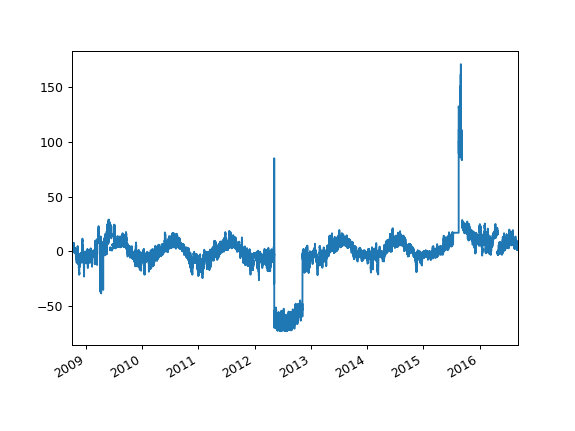

In [19]:
wide_dat.Tpassive1.plot()

In [20]:
wide_dat=wide_dat.reset_index(drop=True).copy() #drop index in output dataframe

In [21]:
save_dat=wide_dat[out_columns]

In [22]:
#directory to save output data
save_pth=base_path+ r"Data/" +Glacier+ r"/AllYears/Wx/LVL0/emily/"
out_nm=Glacier.lower()+ Station + file_label+yr+".csv"

In [23]:
save_dat.to_csv(os.path.join(save_pth, out_nm), index=False, float_format='%g')
print("saved to: ", out_nm)

saved to:  wolverine990_15min_all.csv


In [24]:
#If this is the Nunatak station, fill gaps with Irridium telemetry
if Glacier + Station=='Gulkana1725':
    %run "C:\Users\ehbaker\Documents\Python\WXmunge\Gulkana1725_FillGapsWithIrridium.py"

In [25]:
#If Wolv 990 or Gulkana 1480, add 1990s data from NWIS to extend record back in time
if (Glacier + Station=='Wolverine990') | (Glacier + Station=='Gulkana1480'):    
    %run "C:\Users\ehbaker\Documents\Python\WXmunge\Add1990sDataFromNWIS.py"

1990s data added to logger from NWIS at Wolverine990
wrote data to Q:/Project Data/GlacierData/Benchmark_Program/Data/Wolverine/AllYears/Wx/LVL0/emily/wolverine990_15min_NWIS_1990s_added.csv


In [26]:
save_dat.tail()

,UTC_time,local_time,Tpassive1,Tpassive2,TAspirated1,TAspirated2,RelHum,StageCumulative,TPGCumulative,WindSpeed,WindGustSpeed,WindDir,Barom,VecAvgWindDir,RadiationIn,RadiationOut,SnowDepth,LoggerTemp,LoggerBattery
2017-09-11 00:30:00+00:00,2017/09/11 00:30,2017/09/10 16:30,5.1,NaN,5.0,5.1,94.0,NaN,0.566,3.0,5.0,NaN,-0.606,70.0,NaN,NaN,NaN,8.8,13.9
2017-09-11 00:45:00+00:00,2017/09/11 00:45,2017/09/10 16:45,4.9,NaN,4.9,5.0,94.0,NaN,0.566,2.0,3.0,NaN,-0.604,52.0,NaN,NaN,NaN,9.1,13.9
2017-09-11 01:00:00+00:00,2017/09/11 01:00,2017/09/10 17:00,5.1,NaN,5.1,5.0,94.0,NaN,0.566,2.0,3.0,NaN,-0.601,57.0,NaN,NaN,NaN,9.1,13.9
2017-09-11 01:15:00+00:00,2017/09/11 01:15,2017/09/10 17:15,5.2,NaN,5.2,5.2,93.0,NaN,0.566,2.0,3.0,NaN,-0.594,67.0,NaN,NaN,NaN,9.1,13.9
2017-09-11 01:30:00+00:00,2017/09/11 01:30,2017/09/10 17:30,5.0,NaN,5.2,5.1,93.0,NaN,0.566,2.0,3.0,NaN,-0.582,90.0,NaN,NaN,NaN,10.2,13.8
